# Data Modeling 01

In this notebook, we'll begin building the classifier to show that Layer 4 neurons do not exist in the organoid data. We will do this in the following manner.

1. Identify cells in the primary data by which layer of the cortex they are in.
2. Train a classifier on the primary data.
3. Under the assumption that the space of gene expression is the same in organoids, classify the organoid cells to their respective cortex layer and show that none get classified as layer 4.
4. Conclude that layer 4 cells do not exist in the organoid data.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import umap
import hdbscan
from collections import Counter
import seaborn as sns
import plotly.express as px 
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
primary = pd.read_csv('primary_labels_test.csv')
df = pd.read_csv('../data/processed/primary_reduction_neighbors_500_components_100.csv', index_col='Unnamed: 0')
df['label'] = primary['label']

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,1.174407,4.605017,5.700520,4.349964,0.009240,4.443735,4.977513,1.097707,4.923816,5.728352,...,6.758616,3.999133,4.044898,4.987543,1.790490,4.197807,6.984423,9.260715,7.174916,1
1,1.187639,4.608121,5.704485,4.363834,0.024695,4.443859,4.973516,1.105194,4.919911,5.728892,...,6.762886,3.999778,4.040472,4.999935,1.792208,4.192843,6.986716,9.258625,7.172100,1
2,1.179722,4.631567,5.731539,4.270429,0.007747,4.434293,4.971396,1.129670,4.909443,5.748357,...,6.765180,4.005325,4.039588,5.014343,1.786922,4.206350,6.986751,9.256733,7.179493,5
3,1.233760,4.637250,5.735640,4.311743,0.078151,4.433172,4.963012,1.207390,4.900370,5.740662,...,6.769579,3.998335,4.026979,4.999375,1.817481,4.194461,6.987063,9.243600,7.164564,1
4,1.188722,4.624152,5.721036,4.324148,0.035837,4.437555,4.966181,1.132194,4.908939,5.740864,...,6.764676,4.001324,4.034964,5.004535,1.799192,4.201400,6.986776,9.252455,7.172283,1


Now we begin the classification process

In [53]:
class GeneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=100, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=primary['label'].nunique()),
        )
        
    def forward(self, x):
        return self.network(x)

Now that we've defined a basic fully connected neural network, let's split our data into training and testing sets, then use K-fold CV to tune the architecture of our model

In [54]:
X = df.drop('label', axis=1).values
y = [x+1 for x in df['label'].values] # So we dont have a label value of -1, noise is now label=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Great, now we can define our loss function, optimization algorithmn and a model instance and get to work!

In [55]:
model = GeneClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

GeneClassifier(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=33, bias=True)
  )
)

Finally, we can train our model and view the accuracy on the test set.

In [56]:
epochs = 10000
loss_arr = []

for i in range(1, epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)
    
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 10 Loss: 2.66902232170105
Epoch: 20 Loss: 2.525259017944336
Epoch: 30 Loss: 2.505376100540161
Epoch: 40 Loss: 2.492415428161621
Epoch: 50 Loss: 2.4822139739990234
Epoch: 60 Loss: 2.446274518966675
Epoch: 70 Loss: 2.625608205795288
Epoch: 80 Loss: 2.5188486576080322
Epoch: 90 Loss: 2.4934029579162598
Epoch: 100 Loss: 2.484018087387085
Epoch: 110 Loss: 2.476749897003174
Epoch: 120 Loss: 2.4636309146881104
Epoch: 130 Loss: 2.404916763305664
Epoch: 140 Loss: 2.65163254737854
Epoch: 150 Loss: 2.5171375274658203
Epoch: 160 Loss: 2.5063984394073486
Epoch: 170 Loss: 2.4997661113739014


KeyboardInterrupt: 

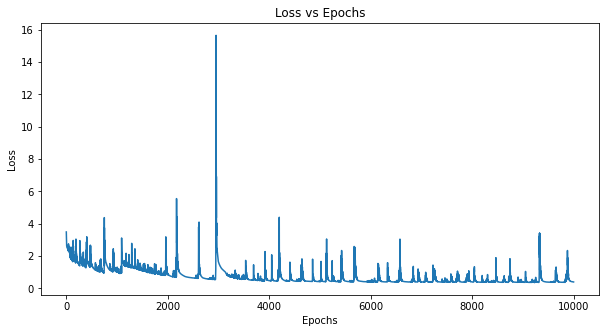

In [48]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs), [x.item() for x in loss_arr]);
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.title('Loss vs Epochs');

In [34]:
loss_arr

[tensor(1.2345, grad_fn=<NllLossBackward0>),
 tensor(1.2341, grad_fn=<NllLossBackward0>),
 tensor(1.2337, grad_fn=<NllLossBackward0>),
 tensor(1.2333, grad_fn=<NllLossBackward0>),
 tensor(1.2329, grad_fn=<NllLossBackward0>),
 tensor(1.2325, grad_fn=<NllLossBackward0>),
 tensor(1.2322, grad_fn=<NllLossBackward0>),
 tensor(1.2318, grad_fn=<NllLossBackward0>),
 tensor(1.2314, grad_fn=<NllLossBackward0>),
 tensor(1.2310, grad_fn=<NllLossBackward0>),
 tensor(1.2306, grad_fn=<NllLossBackward0>),
 tensor(1.2302, grad_fn=<NllLossBackward0>),
 tensor(1.2298, grad_fn=<NllLossBackward0>),
 tensor(1.2295, grad_fn=<NllLossBackward0>),
 tensor(1.2291, grad_fn=<NllLossBackward0>),
 tensor(1.2287, grad_fn=<NllLossBackward0>),
 tensor(1.2283, grad_fn=<NllLossBackward0>),
 tensor(1.2279, grad_fn=<NllLossBackward0>),
 tensor(1.2276, grad_fn=<NllLossBackward0>),
 tensor(1.2272, grad_fn=<NllLossBackward0>),
 tensor(1.2268, grad_fn=<NllLossBackward0>),
 tensor(1.2265, grad_fn=<NllLossBackward0>),
 tensor(1.

We need to train this model much more on the full feature space with regularization methods, so for now let's try some simpler models like SVM's and tree methods

In [34]:
svc = SVC()
parameters = {
    'C': [0.1, 0.25, 0.5, 0.75, 1],
}

est = GridSearchCV(svc, parameters, verbose=100)

In [ ]:
model = est.fit(X_train, y_train).best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
